# Exploratory Data Analysis (EDA) for SQL Server Data

This notebook provides comprehensive data exploration capabilities for your SQL Server tables and views:
1. Data quality assessment
2. Statistical analysis
3. Data visualization
4. Feature selection for ML models
5. Data preprocessing recommendations

In [1]:
# Import required libraries
import sys
import os
import pickle

# Add src to path
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from database.connection import SQLServerConnection
from data.preprocessing import get_data_summary, detect_data_quality_issues

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Connection and Basic Info

In [2]:
# Load connection info from previous notebook
try:
    with open('../data/connection_info.pkl', 'rb') as f:
        connection_info = pickle.load(f)
    
    print("Connection info loaded:")
    for key, value in connection_info.items():
        print(f"  {key}: {value}")
    
    if connection_info.get('connection_verified', False):
        # Recreate connection
        db = SQLServerConnection()
        print("\n✅ Database connection reestablished.")
    else:
        print("\n❌ Previous connection was not verified.")
        
except FileNotFoundError:
    print("Connection info not found. Please run 01_database_connection.ipynb first.")
    db = SQLServerConnection()  # Create anyway for manual setup

Connection info loaded:
  server: localhost\MSSQLSERVER01
  database: stockdata_db
  tables_count: 7
  views_count: 20
  connection_verified: True

✅ Database connection reestablished.


## 2. Load and Explore Your Data

**Update the query below to select data from your specific table/view for ML analysis.**

In [19]:
# Define your data query - UPDATED with RSI trading signals for classification
# This query joins historical data with RSI trading signals
data_query = """
SELECT 
    h.trading_date,
    h.ticker,
    h.company,
    CAST(h.open_price AS FLOAT) as open_price,
    CAST(h.high_price AS FLOAT) as high_price,
    CAST(h.low_price AS FLOAT) as low_price,
    CAST(h.close_price AS FLOAT) as close_price,
    CAST(h.volume AS BIGINT) as volume,
    r.RSI,
    r.rsi_trade_signal
FROM dbo.nasdaq_100_hist_data h
INNER JOIN dbo.nasdaq_100_rsi_signals r 
    ON h.ticker = r.ticker AND h.trading_date = r.trading_date
WHERE h.trading_date >= '2024-01-01'  -- Focus on recent data
ORDER BY h.trading_date DESC, h.ticker
"""

# Alternative queries for different ML objectives:
# 
# 1. For PRICE PREDICTION (Regression):
# data_query = "SELECT * FROM dbo.nasdaq_100_hist_data WHERE trading_date >= '2024-01-01'"
# target_column = 'close_price'
#
# 2. For MACD SIGNALS (Classification):
# Use: dbo.nasdaq_100_macd_signals and target_column = 'macd_signal'
#
# 3. For BOLLINGER BAND SIGNALS (Classification):
# Use: dbo.nasdaq_100_bb_signals and target_column = 'bb_signal'



In [20]:
# Load the data
try:
    print("Executing data query...")
    df = db.execute_query(data_query)
    
    print(f"✅ Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Display first few rows
    print("\nFirst 5 rows:")
    display(df.head())
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please update the data_query above with a valid SQL query.")
    # Create dummy data for demonstration
    df = pd.DataFrame({
        'feature1': np.random.randn(100),
        'feature2': np.random.randint(0, 10, 100),
        'target': np.random.choice([0, 1], 100)
    })
    print("\nUsing dummy data for demonstration.")

Executing data query...
2025-11-25 16:16:50,084 INFO sqlalchemy.engine.Engine BEGIN (implicit)


2025-11-25 16:16:50,091 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE ([INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) OR [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max))) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2025-11-25 16:16:50,094 INFO sqlalchemy.engine.Engine [cached since 944.8s ago] ('BASE TABLE', 'VIEW', "\nSELECT \n    h.trading_date,\n    h.ticker,\n    h.company,\n    CAST(h.open_price AS FLOAT) as open_price,\n    CAST(h.high_price AS FLOAT) as hig ... (276 characters truncated) ... r.ticker AND h.trading_date = r.trading_date\nWHERE h.trading_date >= '2024-01-01'  -- Focus on recent data\nORDER BY h.trading_date DESC, h.ticker\n", 'dbo')
2025-11-25 16:16:50,094 INFO sqlalchemy.engine.Engine [cached since 944.8s ago] ('BASE TABLE', 'VIEW', "\nSELE

,trading_date,ticker,company,open_price,high_price,low_price,close_price,volume,RSI,rsi_trade_signal
0,2025-11-24,AAPL,Apple Inc.,270.90,277.00,270.90,275.92,65504400,59.806538,None
1,2025-11-24,ADBE,Adobe Inc.,325.00,325.77,318.34,318.73,5410900,36.323239,None
2,2025-11-24,ADP,"Automatic Data Processing, Inc.",252.62,252.79,248.33,250.10,3502300,32.033097,None
3,2025-11-24,ADSK,"Autodesk, Inc.",291.35,292.80,288.95,289.85,3027600,35.471101,None
4,2025-11-24,AEP,"American Electric Power Company, Inc.",120.77,122.84,119.59,122.04,6415300,57.310924,None


## 3. Data Summary and Quality Assessment

In [21]:
# Get comprehensive data summary
data_summary = get_data_summary(df)

print("=== DATA SUMMARY ===")
print(f"Shape: {data_summary['shape']}")
print(f"\nNumerical columns: {data_summary['numerical_columns']}")
print(f"Categorical columns: {data_summary['categorical_columns']}")
print(f"DateTime columns: {data_summary['datetime_columns']}")

print("\n=== MISSING VALUES ===")
missing_data = pd.DataFrame.from_dict(data_summary['missing_values'], orient='index', columns=['Missing Count'])
missing_data['Missing %'] = (missing_data['Missing Count'] / len(df)) * 100
missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing %', ascending=False)

if len(missing_data) > 0:
    display(missing_data)
else:
    print("No missing values found! ✅")

=== DATA SUMMARY ===
Shape: (41346, 10)

Numerical columns: ['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'RSI']
Categorical columns: ['trading_date', 'ticker', 'company', 'rsi_trade_signal']
DateTime columns: []

=== MISSING VALUES ===


,Missing Count,Missing %
rsi_trade_signal,30053,72.686596


In [22]:
# Data quality assessment
quality_issues = detect_data_quality_issues(df)

print("=== DATA QUALITY ISSUES ===")
print(f"Duplicate rows: {quality_issues['duplicates']}")

if quality_issues['high_cardinality_columns']:
    print("\nHigh cardinality columns (may need special handling):")
    for col, count in quality_issues['high_cardinality_columns'].items():
        print(f"  {col}: {count} unique values")

if quality_issues['low_variance_columns']:
    print("\nLow variance columns (consider removing):")
    for col in quality_issues['low_variance_columns']:
        print(f"  {col}")

if quality_issues['potential_outliers']:
    print("\nColumns with potential outliers:")
    for col, info in quality_issues['potential_outliers'].items():
        print(f"  {col}: {info}")

=== DATA QUALITY ISSUES ===
Duplicate rows: 0

Columns with potential outliers:
  open_price: 4117 (9.96%)
  high_price: 4112 (9.95%)
  low_price: 4111 (9.94%)
  close_price: 4111 (9.94%)
  volume: 4928 (11.92%)
  RSI: 51 (0.12%)


## 4. Statistical Analysis

=== NUMERICAL FEATURES STATISTICS ===


,open_price,high_price,low_price,close_price,volume,RSI
count,41346.000000,41346.000000,41346.000000,41346.000000,4.134600e+04,41346.000000
mean,280.445655,283.803688,276.899712,280.394710,1.212026e+07,51.798210
std,539.345398,545.337785,532.942399,539.395798,3.520145e+07,17.828742
min,2.900000,3.010000,2.700000,2.880000,0.000000e+00,0.000000
25%,70.332500,71.150000,69.500000,70.260000,1.553925e+06,39.117854
50%,144.731500,146.590000,142.762000,144.856500,3.569150e+06,51.657355
75%,271.405000,274.617500,268.172750,271.451250,8.887300e+06,64.412425
max,5815.000000,5839.410000,5707.930000,5815.920000,8.751980e+08,100.000000


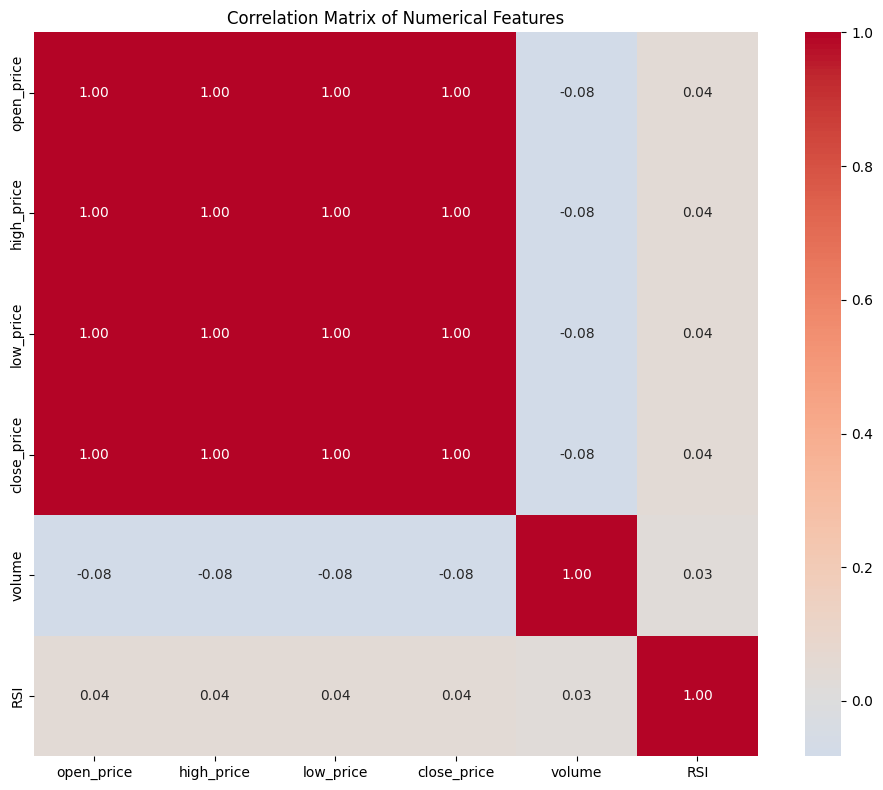


Highly correlated feature pairs (|correlation| > 0.8):
  open_price - high_price: 1.000
  open_price - low_price: 1.000
  open_price - close_price: 1.000
  high_price - low_price: 1.000
  high_price - close_price: 1.000
  low_price - close_price: 1.000


In [23]:
# Basic statistics for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if numerical_cols:
    print("=== NUMERICAL FEATURES STATISTICS ===")
    display(df[numerical_cols].describe())
    
    # Correlation matrix
    if len(numerical_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.2f')
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()
        plt.show()
        
        # Find highly correlated features
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                if abs(correlation_matrix.iloc[i, j]) > 0.8:
                    high_corr_pairs.append((
                        correlation_matrix.columns[i],
                        correlation_matrix.columns[j],
                        correlation_matrix.iloc[i, j]
                    ))
        
        if high_corr_pairs:
            print("\nHighly correlated feature pairs (|correlation| > 0.8):")
            for col1, col2, corr in high_corr_pairs:
                print(f"  {col1} - {col2}: {corr:.3f}")
else:
    print("No numerical columns found.")

=== CATEGORICAL FEATURES ANALYSIS ===

trading_date:
  Unique values: 425
  Most common: 2025-06-18 (388 occurrences)
  Top 10 values: [datetime.date(2025, 6, 18), datetime.date(2024, 4, 1), datetime.date(2024, 9, 9), datetime.date(2024, 4, 30), datetime.date(2024, 4, 22), datetime.date(2024, 4, 23), datetime.date(2024, 8, 16), datetime.date(2024, 5, 20), datetime.date(2024, 5, 17), datetime.date(2024, 5, 16)]

ticker:
  Unique values: 97
  Most common: AAPL (428 occurrences)
  Top 10 values: ['AAPL', 'ADBE', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMZN', 'ASML', 'AVGO']

company:
  Unique values: 96
  Most common: Fox Corporation (856 occurrences)
  Top 10 values: ['Fox Corporation', 'Apple Inc.', 'Automatic Data Processing, Inc.', 'Adobe Inc.', 'American Electric Power Company, Inc.', 'Applied Materials, Inc.', 'Advanced Micro Devices, Inc.', 'Autodesk, Inc.', 'ASML Holding N.V.', 'Broadcom Inc.']

rsi_trade_signal:
  Unique values: 2
  Most common: Overbought (Sell) (6562 occurrences)

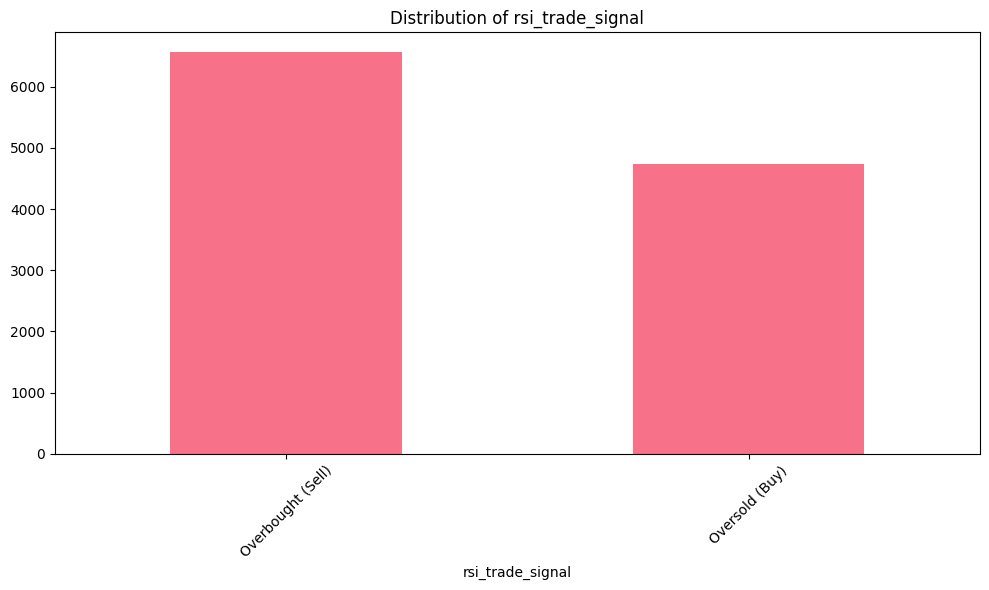

In [24]:
# Categorical features analysis
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    print("=== CATEGORICAL FEATURES ANALYSIS ===")
    
    for col in categorical_cols[:5]:  # Limit to first 5 categorical columns
        print(f"\n{col}:")
        value_counts = df[col].value_counts()
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Most common: {value_counts.index[0]} ({value_counts.iloc[0]} occurrences)")
        
        # Plot if not too many categories
        if df[col].nunique() <= 10:
            plt.figure(figsize=(10, 6))
            value_counts.plot(kind='bar')
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"  Top 10 values: {list(value_counts.head(10).index)}")
else:
    print("No categorical columns found.")

## 5. Data Distribution Visualization

=== NUMERICAL FEATURES DISTRIBUTIONS ===


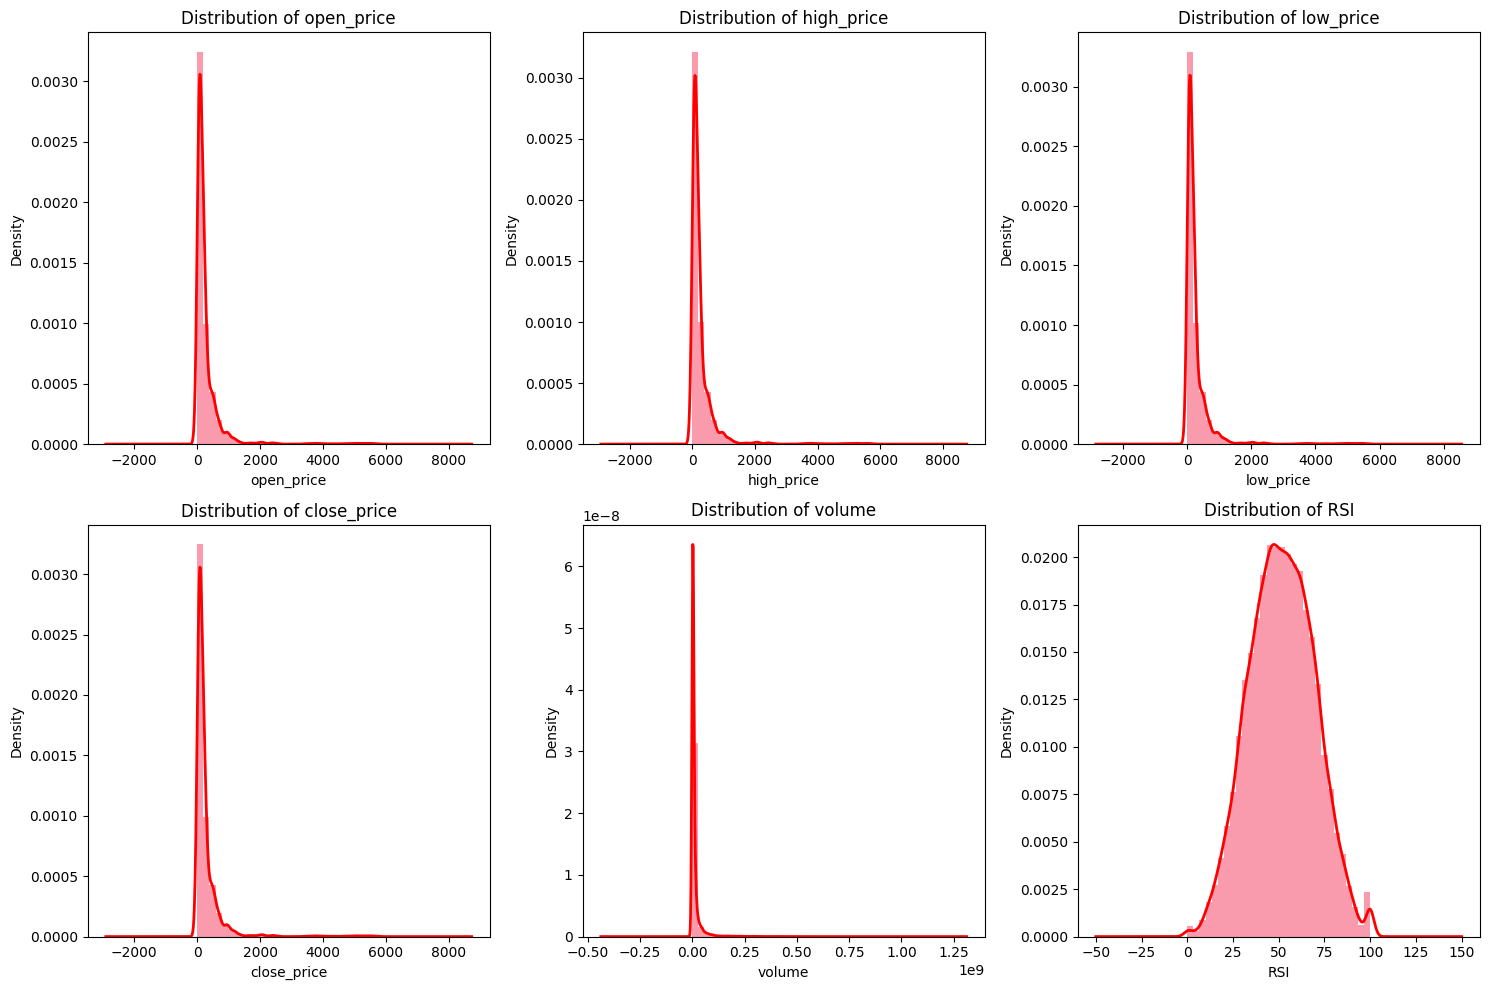

In [25]:
# Distribution plots for numerical features
if len(numerical_cols) > 0:
    print("=== NUMERICAL FEATURES DISTRIBUTIONS ===")
    
    # Create subplots
    n_cols = min(3, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        if i >= len(axes):
            break
            
        # Histogram with density curve
        axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, density=True)
        
        # Add density curve
        try:
            df[col].dropna().plot.density(ax=axes[i], color='red', linewidth=2)
        except:
            pass
            
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide empty subplots
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

=== OUTLIER DETECTION (BOX PLOTS) ===


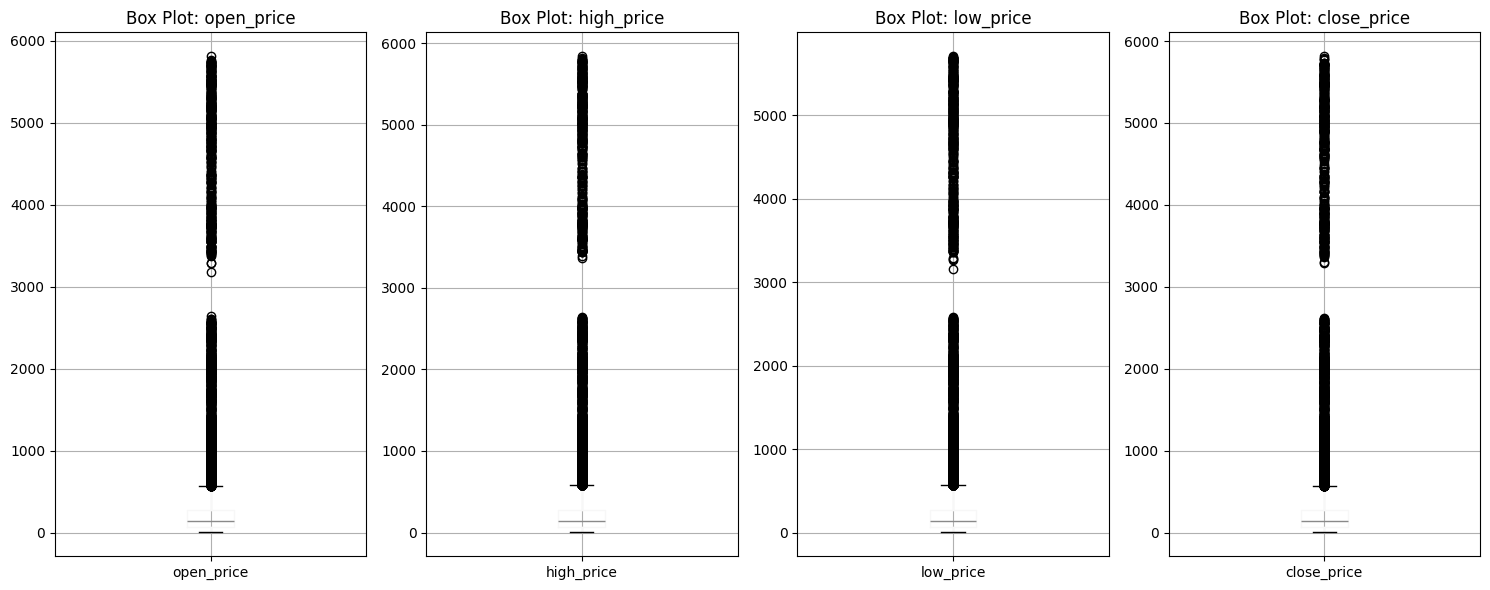

In [26]:
# Box plots for outlier detection
if len(numerical_cols) > 0:
    print("=== OUTLIER DETECTION (BOX PLOTS) ===")
    
    fig, axes = plt.subplots(1, min(4, len(numerical_cols)), figsize=(15, 6))
    if len(numerical_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(numerical_cols[:4]):
        if i >= len(axes):
            break
            
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'Box Plot: {col}')
    
    plt.tight_layout()
    plt.show()

## 6. Feature Relationships and Target Analysis

**Update 'target_column' below with your actual target variable for ML.**

=== TARGET COLUMN OPTIONS ===
Current target: rsi_trade_signal

📊 CLASSIFICATION TARGETS:
  • rsi_trade_signal - Trading signals (Buy/Sell/Neutral)
  • macd_signal - MACD-based trading signals
  • bb_signal - Bollinger Band signals

📈 REGRESSION TARGETS:
  • close_price - Predict closing prices
  • high_price - Predict daily highs
  • low_price - Predict daily lows
  • RSI - Predict RSI values

🎯 ENGINEERED TARGETS (you can create these):
  • price_direction - Binary: 1 if close > open, 0 otherwise
  • next_day_return - (tomorrow_close - today_close) / today_close
  • volatility_level - High/Normal based on daily range

✅ Target column 'rsi_trade_signal' found in dataset.

=== TARGET VARIABLE ANALYSIS ===
Target: rsi_trade_signal
Data type: object
Unique values: 2
Target type: Classification

Class distribution:


rsi_trade_signal
Overbought (Sell)    6562
Oversold (Buy)       4731
Name: count, dtype: int64


Class percentages:
  Overbought (Sell): 15.9%
  Oversold (Buy): 11.4%


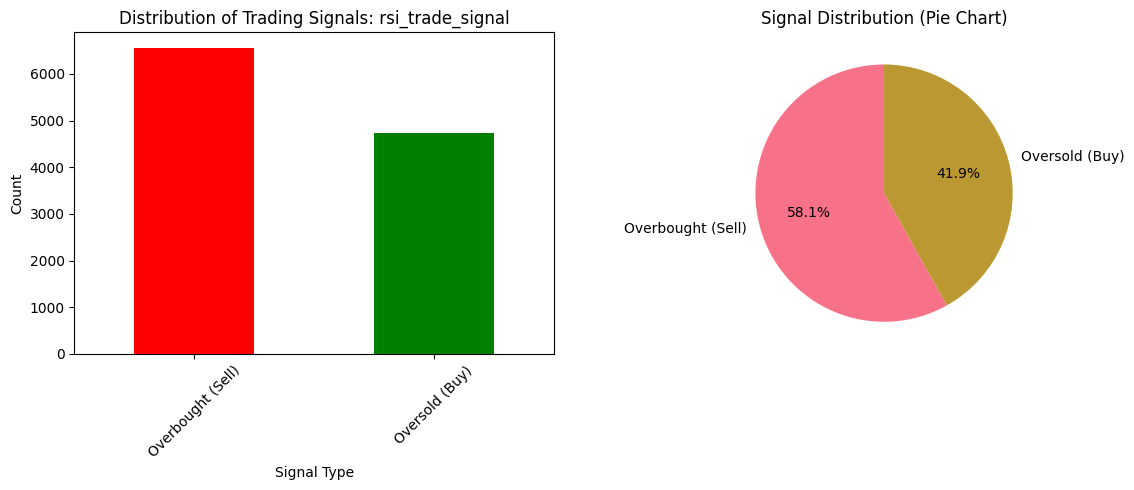

In [27]:
# Define your target column - UPDATED with RSI trading signals
# This is perfect for classification models predicting Buy/Sell/Neutral signals
target_column = 'rsi_trade_signal'

# Alternative target options for different ML objectives:
print("=== TARGET COLUMN OPTIONS ===")
print("Current target:", target_column)
print("")
print("📊 CLASSIFICATION TARGETS:")
print("  • rsi_trade_signal - Trading signals (Buy/Sell/Neutral)")
print("  • macd_signal - MACD-based trading signals")
print("  • bb_signal - Bollinger Band signals")
print("")
print("📈 REGRESSION TARGETS:")
print("  • close_price - Predict closing prices")
print("  • high_price - Predict daily highs")
print("  • low_price - Predict daily lows")
print("  • RSI - Predict RSI values")
print("")
print("🎯 ENGINEERED TARGETS (you can create these):")
print("  • price_direction - Binary: 1 if close > open, 0 otherwise")
print("  • next_day_return - (tomorrow_close - today_close) / today_close")
print("  • volatility_level - High/Normal based on daily range")

# Check if target column exists
if target_column in df.columns:
    target_exists = True
    print(f"\n✅ Target column '{target_column}' found in dataset.")
    
    # Analyze target variable
    print(f"\n=== TARGET VARIABLE ANALYSIS ===")
    print(f"Target: {target_column}")
    print(f"Data type: {df[target_column].dtype}")
    print(f"Unique values: {df[target_column].nunique()}")
    
    if df[target_column].dtype in ['object', 'category'] or df[target_column].nunique() < 10:
        # Classification target
        print("Target type: Classification")
        target_counts = df[target_column].value_counts()
        print("\nClass distribution:")
        display(target_counts)
        
        # Calculate class balance
        class_balance = target_counts / len(df) * 100
        print("\nClass percentages:")
        for cls, pct in class_balance.items():
            print(f"  {cls}: {pct:.1f}%")
        
        # Plot target distribution
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        target_counts.plot(kind='bar', color=['green' if 'Buy' in str(x) else 'red' if 'Sell' in str(x) else 'gray' for x in target_counts.index])
        plt.title(f'Distribution of Trading Signals: {target_column}')
        plt.xlabel('Signal Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        target_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
        plt.title('Signal Distribution (Pie Chart)')
        plt.ylabel('')
        
        plt.tight_layout()
        plt.show()
        
        # Check for class imbalance
        min_class_pct = class_balance.min()
        if min_class_pct < 10:
            print(f"⚠️  Warning: Class imbalance detected. Smallest class: {min_class_pct:.1f}%")
            print("   Consider using stratified sampling or class weighting in your models.")
        
    else:
        # Regression target
        print("Target type: Regression")
        print(f"\nStatistics:")
        display(df[target_column].describe())
        
        # Plot target distribution
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        df[target_column].hist(bins=30, alpha=0.7, color='skyblue')
        plt.title(f'Distribution of {target_column}')
        plt.xlabel(target_column)
        plt.ylabel('Frequency')
        
        plt.subplot(1, 3, 2)
        df[target_column].plot(kind='box', color='lightgreen')
        plt.title(f'Box Plot of {target_column}')
        
        plt.subplot(1, 3, 3)
        # Time series plot if we have date column
        if 'trading_date' in df.columns:
            daily_avg = df.groupby('trading_date')[target_column].mean()
            daily_avg.plot()
            plt.title(f'Average {target_column} Over Time')
            plt.xticks(rotation=45)
        else:
            df[target_column].plot()
            plt.title(f'{target_column} Values')
        
        plt.tight_layout()
        plt.show()
        
else:
    target_exists = False
    print(f"\n❌ Target column '{target_column}' not found in dataset.")
    print(f"Available columns: {list(df.columns)}")
    print("\n💡 Try one of these available columns as your target:")
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['signal', 'price', 'rsi', 'macd', 'return']):
            print(f"   • {col}")

In [28]:
# Feature-target relationships
if target_exists and len(numerical_cols) > 1:
    print("=== FEATURE-TARGET RELATIONSHIPS ===")
    
    # Correlation with target (for numerical features)
    feature_cols = [col for col in numerical_cols if col != target_column]
    
    if feature_cols and target_column in numerical_cols:
        correlations = df[feature_cols + [target_column]].corr()[target_column].drop(target_column)
        correlations_sorted = correlations.abs().sort_values(ascending=False)
        
        print("Feature correlations with target (sorted by absolute value):")
        for feature, corr in correlations_sorted.items():
            print(f"  {feature}: {correlations[feature]:.3f}")
        
        # Plot top correlations
        plt.figure(figsize=(10, 6))
        correlations_sorted.head(10).plot(kind='barh')
        plt.title('Top 10 Feature Correlations with Target (Absolute Values)')
        plt.xlabel('Absolute Correlation')
        plt.tight_layout()
        plt.show()
    
    # Scatter plots for top correlated features
    if feature_cols and target_column in numerical_cols and len(feature_cols) > 0:
        top_features = correlations_sorted.head(4).index.tolist()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        for i, feature in enumerate(top_features[:4]):
            axes[i].scatter(df[feature], df[target_column], alpha=0.6)
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel(target_column)
            axes[i].set_title(f'{feature} vs {target_column} (corr: {correlations[feature]:.3f})')
        
        plt.tight_layout()
        plt.show()

=== FEATURE-TARGET RELATIONSHIPS ===


## 7. Data Preprocessing Recommendations

In [29]:
print("=== DATA PREPROCESSING RECOMMENDATIONS ===")

recommendations = []

# Missing values
missing_cols = [col for col, count in data_summary['missing_values'].items() if count > 0]
if missing_cols:
    recommendations.append(f"Handle missing values in: {missing_cols}")
    recommendations.append("  - Use mean/median for numerical columns")
    recommendations.append("  - Use mode or create 'Unknown' category for categorical columns")

# Categorical encoding
if categorical_cols:
    recommendations.append(f"Encode categorical variables: {categorical_cols}")
    recommendations.append("  - Use one-hot encoding for low cardinality (< 10 categories)")
    recommendations.append("  - Use label encoding or target encoding for high cardinality")

# Feature scaling
if numerical_cols:
    recommendations.append("Consider feature scaling for numerical variables:")
    recommendations.append("  - StandardScaler for normally distributed features")
    recommendations.append("  - MinMaxScaler for bounded features")

# Outlier handling
if quality_issues['potential_outliers']:
    outlier_cols = list(quality_issues['potential_outliers'].keys())
    recommendations.append(f"Consider outlier treatment for: {outlier_cols}")
    recommendations.append("  - Use IQR method or Z-score for detection")
    recommendations.append("  - Options: remove, cap, or transform outliers")

# Feature selection
if len(numerical_cols) > 10:
    recommendations.append("Consider feature selection techniques:")
    recommendations.append("  - Remove highly correlated features")
    recommendations.append("  - Use statistical tests or tree-based importance")

# Low variance features
if quality_issues['low_variance_columns']:
    recommendations.append(f"Consider removing low variance features: {quality_issues['low_variance_columns']}")

# Print recommendations
if recommendations:
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
else:
    print("No specific preprocessing recommendations. Data looks clean!")

print("\n=== NEXT STEPS ===")
print("1. Update the target_column variable if you haven't already")
print("2. Apply preprocessing based on the recommendations above")
print("3. Move to '03_model_development.ipynb' to build ML models")
print("4. Consider feature engineering based on domain knowledge")

=== DATA PREPROCESSING RECOMMENDATIONS ===
1. Handle missing values in: ['rsi_trade_signal']
2.   - Use mean/median for numerical columns
3.   - Use mode or create 'Unknown' category for categorical columns
4. Encode categorical variables: ['trading_date', 'ticker', 'company', 'rsi_trade_signal']
5.   - Use one-hot encoding for low cardinality (< 10 categories)
6.   - Use label encoding or target encoding for high cardinality
7. Consider feature scaling for numerical variables:
8.   - StandardScaler for normally distributed features
9.   - MinMaxScaler for bounded features
10. Consider outlier treatment for: ['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'RSI']
11.   - Use IQR method or Z-score for detection
12.   - Options: remove, cap, or transform outliers

=== NEXT STEPS ===
1. Update the target_column variable if you haven't already
2. Apply preprocessing based on the recommendations above
3. Move to '03_model_development.ipynb' to build ML models
4. Consider f

In [31]:
# Save exploration results for next notebook
exploration_results = {
    'data_shape': df.shape,
    'numerical_columns': numerical_cols,
    'categorical_columns': categorical_cols,
    'target_column': target_column if target_exists else None,
    'target_exists': target_exists,
    'missing_values_summary': {col: count for col, count in data_summary['missing_values'].items() if count > 0},
    'quality_issues': quality_issues,
    'preprocessing_recommendations': recommendations
}

# Save to file
with open('../data/exploration_results.pkl', 'wb') as f:
    pickle.dump(exploration_results, f)

print("✅ Exploration results saved to data/exploration_results.pkl")
print("\nReady to proceed with model development! 🚀")

✅ Exploration results saved to data/exploration_results.pkl

Ready to proceed with model development! 🚀


In [32]:
import pickle
import pandas as pd

# Load saved results
try:
    with open('../data/exploration_results.pkl', 'rb') as f:
        results = pickle.load(f)
    
    print("=== ACTUAL EXPLORATION RESULTS ===")
    print(f"Data Shape: {results['data_shape']}")
    print(f"Target Column: {results['target_column']}")
    print(f"Target Exists: {results['target_exists']}")
    print(f"Numerical Columns: {len(results['numerical_columns'])}")
    print(f"Categorical Columns: {len(results['categorical_columns'])}")
    print(f"Missing Values: {results['missing_values_summary']}")
    print(f"Quality Issues: {results['quality_issues']}")
    
except FileNotFoundError:
    print("Results file not found. Please run the exploration notebook first.")

=== ACTUAL EXPLORATION RESULTS ===
Data Shape: (41346, 10)
Target Column: rsi_trade_signal
Target Exists: True
Numerical Columns: 6
Categorical Columns: 4
Missing Values: {'rsi_trade_signal': 30053}
Quality Issues: {'missing_values': {'rsi_trade_signal': '72.69%'}, 'duplicates': 0, 'high_cardinality_columns': {}, 'low_variance_columns': [], 'potential_outliers': {'open_price': '4117 (9.96%)', 'high_price': '4112 (9.95%)', 'low_price': '4111 (9.94%)', 'close_price': '4111 (9.94%)', 'volume': '4928 (11.92%)', 'RSI': '51 (0.12%)'}}
